# Forecasting of daily River Discharge (RD) based on temperature and previous precipitation levels

### Import of libraries

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import matplotlib.dates as mdates
from sklearn import linear_model,preprocessing
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error,r2_score

#### Fuctions

### LoadingData

In [124]:
data=pd.read_csv("RD_data/RD_NeivaR_pg.csv").values
diasBefore = 5
Xbefore = data[:,2:4]
second_colum = Xbefore[:,1]
second_colum = np.roll(second_colum,diasBefore)
new_column = np.expand_dims(second_colum, axis=1)
Xbefore = np.hstack((Xbefore, new_column))
X = Xbefore[diasBefore:,:]
print(X)
RD = data[:,1]
y = data[diasBefore:,1]
dias = data[:,0]

poly = preprocessing.PolynomialFeatures(degree=2)
X = poly.fit_transform(X)
print(X)
temp = data[:,2]
prec = data[:,3]
print(X.shape)

[[16.65 0.0 29.0]
 [16.65 0.0 9.5]
 [16.65 0.0 18.5]
 ...
 [20.7 0.0 0.0]
 [20.7 0.0 0.0]
 [20.7 0.0 0.0]]
[[  1.    16.65   0.   ...   0.     0.   841.  ]
 [  1.    16.65   0.   ...   0.     0.    90.25]
 [  1.    16.65   0.   ...   0.     0.   342.25]
 ...
 [  1.    20.7    0.   ...   0.     0.     0.  ]
 [  1.    20.7    0.   ...   0.     0.     0.  ]
 [  1.    20.7    0.   ...   0.     0.     0.  ]]
(1821, 10)


### Ploting Graphs

Text(0, 0.5, 'Temperature')

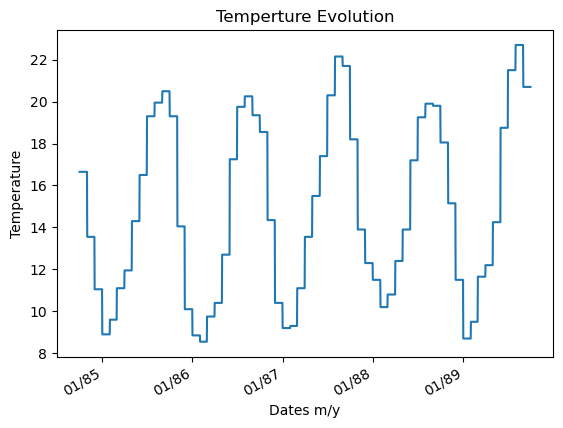

In [125]:
plotDates = [dt.datetime.strptime(d,'%d/%m/%Y').date() for d in dias]


plt.plot(plotDates,temp)
plt.xlabel("Dates m/y")
plt.title("Temperture Evolution")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.gcf().autofmt_xdate()
plt.ylabel("Temperature")

Text(0, 0.5, 'Precipitation')

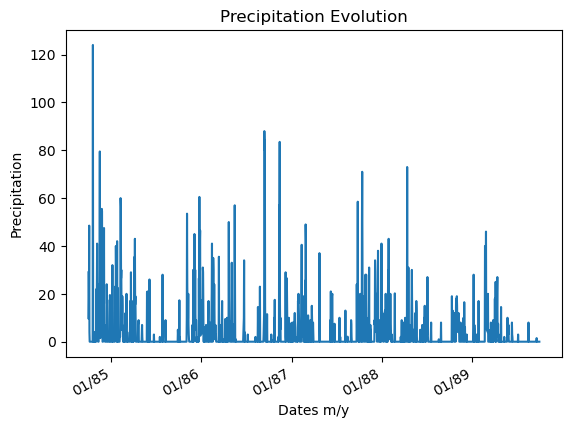

In [126]:
plt.plot(plotDates,prec)
plt.xlabel("Dates m/y")
plt.title("Precipitation Evolution")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.gcf().autofmt_xdate()
plt.ylabel("Precipitation")

Text(0, 0.5, 'River Discharge')

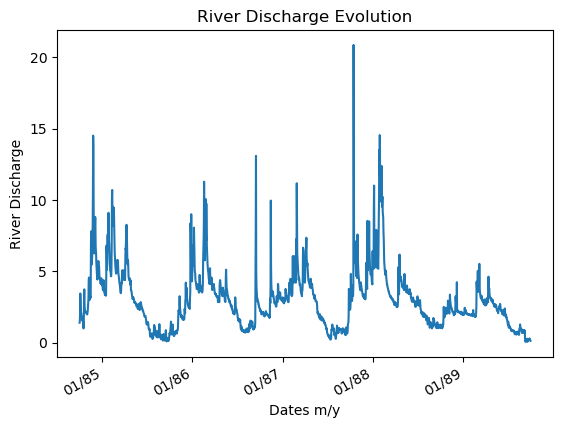

In [127]:
plt.plot(plotDates,RD)
plt.xlabel("Dates m/y")
plt.title("River Discharge Evolution")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
plt.gcf().autofmt_xdate()
plt.ylabel("River Discharge")

### Prep of Data

1821


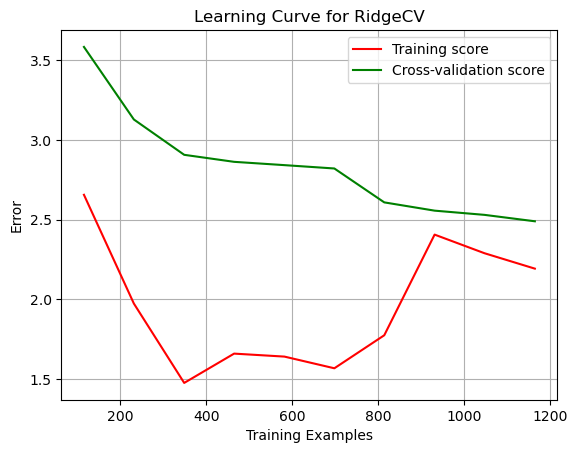

In [128]:
scaler = preprocessing.StandardScaler().fit(X)

X_normalized = scaler.transform(X)
cut = int(len(y)*0.8)
print(len(y))
X_trainN = X_normalized[:cut,:]
y_train = y[:cut]
# X_validationN = X_normalized[949:1265,:]
# y_validation = y[949:1265]
X_testN = X_normalized[cut:,:]
y_test = y[cut:]

# Define a range of alpha values to test
alphas = [0.01,0.1,1,10,100]


ridge_cv = linear_model.RidgeCV(alphas=alphas)

# Create learning curve
train_sizes, train_errors, valid_errors = learning_curve(
    ridge_cv, X_trainN, y_train, train_sizes=np.linspace(0.1, 1.0, 10),scoring=lambda estimator, X, y: mean_squared_error(y, estimator.predict(X)))

# Calculate mean and standard deviation of training and validation errors
train_errors_mean = np.mean(train_errors, axis=1)
train_errors_std = np.std(train_errors, axis=1)
valid_errors_mean = np.mean(valid_errors, axis=1)
valid_errors_std = np.std(valid_errors, axis=1)

# Plot learning curve
plt.figure()
plt.title("Learning Curve for RidgeCV")
plt.xlabel("Training Examples")
plt.ylabel("Error")

plt.grid()

plt.plot(train_sizes, train_errors_mean, '-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_errors_mean, '-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

### Cost Function

R-squared (R2): -0.8999560906949771



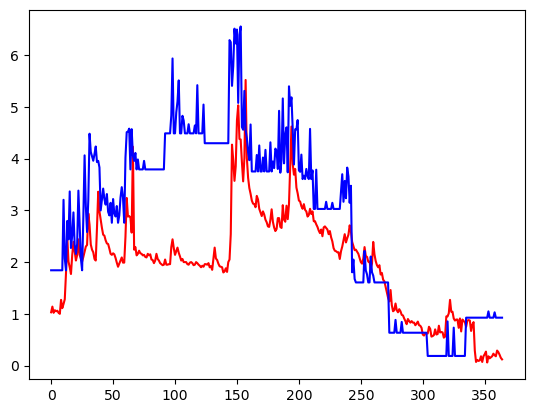

In [129]:
ridge_cv.fit(X_trainN,y_train)
prdict = ridge_cv.predict(X_testN)

plt.plot(y_test,'r')
plt.plot(prdict,'b')
r2 = r2_score(y_test, prdict)
print("R-squared (R2):", r2)
print()